## Search_u_avg (Python Edition)

10 February, 2022



This script containtains 2 functions written within it:

$\textbf{settling_velocity()}$ and $\textbf{avg_profiles_mix()}$

Which are used to compute the flow properties to obtain the following:

• Mixture Density

• Depth Averaged Volumetric Concentation

• $d_{bl}$, the height of the boundary between the logarithmic profile which exists from $y = 0 $ to $y = d_{bl}$ and the free stream profile, which runs from $y = d_{bl}$ to the top of the flow at $y = H$
    

This script also uses the Gaussian Quadrature Integral package from scipy, which is used to compute: 

$$ u^{2} \cdot c$$

Which is then useful for computing the momentum flux of the flow. 


In [17]:
import numpy as numpy 
# np is a variable name so we use the full name here 

from mpmath import *
mp.dps = 15; mp.pretty = True

from scipy.special import lambertw 
# imports the lambert function and returns complex result
# Usage Example:
# lambertw()

import scipy.special as sc
from scipy import integrate
# allows us to use the exponential integral function
# Usage Example:
# sc.expi()

import matplotlib.pyplot as plt


In [18]:
# function settl_vel = settling_velocity(rhos,rhog,diam,grav,kin_visc)

def settling_velocity(rhos,rhog,diam,grav,kin_visc):
    inv_sqrt_C_D = 1.0
    settl_vel = numpy.zeros_like(rhos)
    for i in range(0,len(xs)):
        
        if rhos[i] <= rhog: 
            
            settl_vel[i] = 0.0
           
        else:    

            const_part =  numpy.sqrt( 0.75 * ( rhos[i] / rhog - 1.0 ) * diam[i] * grav )
            
            settl_vel[i] = const_part * inv_sqrt_C_D
            
            Rey = diam[i] * settl_vel[i] / kin_visc

            for j in range(20):
                
                inv_sqrt_C_D = numpy.sqrt( Rey / ( 24.0 * ( 1.0 + 0.15*Rey**0.687 ) ) )
                settl_vel[i] = const_part * inv_sqrt_C_D;
                Rey = diam[i] * settl_vel[i] / kin_visc
                
    return settl_vel
    

In [19]:
rel_tol = 1.e-10 
abs_tol = 1.e-8 

print('')
# this (when multiplied by h) is one of the conservative variable of the system of PDEs.
uRho_avg = 10.0     # depth-averaged u(z)*rhom(z)  [kg/(m2 s)]

# computed by dividing the first conservative variable by mixture density
h = 10.00            # flow thickness [m]

# solid mass fractions (computed from ratio of conservative variables)
xs = numpy.zeros(3)
xs[0] = 0.65 
xs[1] = 0.15
xs[2] = 0.10

np = len(xs) 

# gas density can be computed from mixture temperature, which is obtained from the 
# conservative variables ( T = (h*rhom*Cv*T)/(Cv*h*rhom) )
rhog = 1.1           # [kg/m3]
kin_visc = 1.48e-5   # [m2/s]
grav = 9.81          # [m/s2]

# particles densities [kg/m3]
rhos = numpy.zeros_like(xs)
rhos[0] = 1000 
rhos[1] = 2000
rhos[2] = 1500

# particles diameters [m]
diam = numpy.zeros_like(xs)
diam[0] = 1.e-3 
diam[1] = 1.e-4
diam[2] = 1.e-5

# particles settling velocities [m/s]
settl_vel = settling_velocity(rhos,rhog,diam,grav,kin_visc) 

# fixed parameters
k = 0.4                 # Von Karman constant
friction_coeff = 0.01   # friction coefficient
k_s = 1.5               # substrate roughness [m] 
beta = 1.0              # ratio of momentum and mass diffusivity (Schmidt number)


# gas mass fraction
xg = 1.0 - sum(xs) 

# mixture density
rhom = 1.0/ ( xg/rhog + sum(xs/rhos) ) 

print('Mixture density computed from mass fractions (kg/m3)',
      '                   =',round(rhom,12))

# depth-averaged volumetric fractions
alpha_avg = xs/rhos*rhom     

for i in range(0,np):
    print('Depth-averaged alpha(1) computed from mass fractions','[',i+1,']',
          '             =',round(alpha_avg[i],13))
    
print('Total solid depth-averaged volume fraction computed from mass fractions =',
      round(sum(alpha_avg),14))

# this is the depth-averaged value of rhos*alpha(z), which is equal to the
# depth-averaged  value  of xs*rhom(z). So it is the conservative variable 
# used for the solid mass divided by h.
rhoAlpha_avg = rhos*alpha_avg 

# H_crit is a critical thickness above  which there is a constant free stream velocity.
# Below  H_crit  we  only  have  the  log  profile. H_crit is a function of k, k_s and 
# friction_coeff only. H_crit_rel  is  the  non-dimensional crtitical thickness, which 
# depends on k and the friction coefficient only

a = k/numpy.sqrt(friction_coeff)+1.0 
H_crit_rel = numpy.real(1.0/30.0 * ( -a / lambertw(-a*numpy.exp(-a)) -1.0 ))
print('Log region thickness (meters)                                           =',
     round( H_crit_rel*k_s,13)) 


Mixture density computed from mass fractions (kg/m3)                    = 10.905035317444
Depth-averaged alpha(1) computed from mass fractions [ 1 ]              = 0.0070882729563
Depth-averaged alpha(1) computed from mass fractions [ 2 ]              = 0.0008178776488
Depth-averaged alpha(1) computed from mass fractions [ 3 ]              = 0.0007270023545
Total solid depth-averaged volume fraction computed from mass fractions = 0.00863315295964
Log region thickness (meters)                                           = 7.1162460797028


In [20]:
def avg_profiles_mix(h,settl_vel,k,friction_coeff,rhoalpha_avg,u_guess,
                     beta,h0,b,u_coeff,u_rel0,rhos,rhog):

    u_star        = u_guess * numpy.sqrt(friction_coeff)
    Pn            = settl_vel / ( k * u_star )
    np            = len(settl_vel)
    rho_u_alphas  = numpy.zeros(np)
    rhoalphas_int = numpy.zeros(np)

    for i in range(len(settl_vel)):

        a              = -(6.0*Pn[i]*beta)/h
        int_           = ( ( numpy.exp(a*h0) -1.0 )/a + numpy.exp(a*h0)*(h-h0) )/h
        
        alphas_rel_max = 1.0/int_
        alphas_rel0 = alphas_rel_max * numpy.exp(a*h0)
    
        rhoalphas_int[i] = rhoalpha_avg[i] * ( alphas_rel_max * ( numpy.exp(a*h0) - 1.0 ) / a + (h-h0)*alphas_rel0 ) / h  

        y = h0
        int_h0 = ( numpy.exp(a*y)*numpy.log(b*y+1.0) + numpy.exp(-a/b) * sc.exp1( -a*(y+1.0/b) ) ) / a
        
        y = 0
        int_0 = ( numpy.exp(a*y)*numpy.log(b*y+1.0) + numpy.exp(-a/b) * sc.exp1( -a*(y+1.0/b) ) ) / a
        
        int_def = u_coeff * numpy.sqrt(friction_coeff) / k * alphas_rel_max * (int_h0-int_0)
        
        
        rho_u_alphas[i] = rhoalpha_avg[i] * u_guess * ( int_def + ( h - h0 ) * alphas_rel0 * u_rel0 ) / h
    
    rhom_avg = rhog + sum((rhos-rhog)/rhos*rhoalphas_int)
    uRho_avg_new = ( u_guess*rhog + sum((rhos-rhog)/rhos*rho_u_alphas) )
    
    return rhom_avg,uRho_avg_new

In [21]:
# The profile parameters depend on h/k_s, not on the absolute value of h.
h_rel = h/k_s 

if (h_rel > H_crit_rel):

    # we search for h0_rel such that the average integral between 0 and
    # h_rel is equal to 1 For h_rel > H_crit_rel  this  integral is the 
    # sum of  two  pieces:  integral  between  0  and h0_rel of the log 
    # profile integral between h0_rel and h_rel of  the costant profile

    a = h_rel * k/numpy.sqrt(friction_coeff) 
    b = 1.0/30.0 + h_rel 
    c = 30.0 

    # solve b*log(c*z+1)-z=a for z
    d = a/b-1.0/(b*c) 

    h0_rel = numpy.real(-b*lambertw( -numpy.exp(d)/(b*c) ) - 1.0 / c )
    u_coeff = 1.0 

else:

    # when h_rel <= H_crit_rel we have only the log profile and we have to
    # rescale it in order to have the integral between o and h_rel equal to 1
    # The factor used to scale the velocity is u_coeff

    h0_rel = h_rel 
    u_coeff = k/numpy.sqrt(friction_coeff)/( ( 1 + 1/(30*h_rel) )*numpy.log( 30.0*h_rel + 1.0 )-1.0) 

h0 = h0_rel*k_s 
b = 30.0/k_s 
u_rel0 = u_coeff * numpy.sqrt(friction_coeff) / k * numpy.log( b*h0 + 1.0 )     

In [22]:
# h0 = h0_rel*k_s 
# b = 30.0/k_s 
# u_rel0 = u_coeff * numpy.sqrt(friction_coeff) / k * numpy.log( b*h0 + 1.0 ) 

In [23]:
# search convergence of u_avg
n = 200

u_avg_guess = uRho_avg / rhom 
x0 = u_avg_guess 


# loop to compute the average velocity from average rho*alpha and average 
# uRho ( = 1/h*int( u*rhog*alphag + sum[u*rhos(i)*alphas(i)] ) ) 
print()
#     avg_profiles_mix function returns ([rhom_avg,uRho_avg_new])

for i in range(0,n):
    
    x0 = u_avg_guess 
    
    rhom_avg,uRho_avg_new = avg_profiles_mix(h,settl_vel,k,friction_coeff,rhoAlpha_avg,u_avg_guess,
                                             beta,h0,b,u_coeff,u_rel0,rhos,rhog)

    u_avg_new = u_avg_guess * uRho_avg / ( uRho_avg_new) 

    x1 = u_avg_new 

    rhom_avg,uRho_avg_new = avg_profiles_mix(h,settl_vel,k,friction_coeff,rhoAlpha_avg,u_avg_new,
                                             beta,h0,b,u_coeff,u_rel0,rhos,rhog)
    
    u_avg_new = u_avg_new * uRho_avg / ( uRho_avg_new) 
     
    x2 = u_avg_new 

    if (x1 != x0):
        lambda_ = abs((x2 - x1)/(x1 - x0))   #OPTIONAL: Computes an approximation of |f'(fixedPoint)|, which is denoted by lambda

    denominator = (x2 - x1) - (x1 - x0) 
    
    if (abs(denominator) < 0.1*abs_tol):        #To avoid greatly increasing error, do not divide by too small of a number
        print('')
        print('                     –––––––                      ')
        print('****************** Ending Loop *******************')
        print('******** WARNING: denominator is too small *******')
        break                                       #Leave the loop

    aitkenX = x2 - ( (x2 - x1)**2 )/denominator 

    u_avg_new = aitkenX    

    if ( abs(u_avg_guess-u_avg_new)/u_avg_guess < rel_tol ) or ( abs(u_avg_guess-u_avg_new) < abs_tol ):
        u_avg_guess = u_avg_new 
        
    u_avg_guess = u_avg_new 

    print('Iteration #',i+1, '–––> u_guess =',round(u_avg_new,14), ' m/s')

   
print('                     –––––––                      '       ) 
print('                                                         ')
print('Total Iterations           = ',                        i  )
print('u_final                    = ',round(u_avg_new,13),'m/s'  ) 
print('Depth-averaged rho         = ',round(rhom_avg,12 ),'kg/m3')

# average velocity
u_avg = u_avg_new 

# shear velocty
u_star = u_avg * numpy.sqrt(friction_coeff) 

# Rouse numbers for different particles
Pn = settl_vel / ( k * u_star ) 


Iteration # 1 –––> u_guess = 2.45967393070447  m/s
Iteration # 2 –––> u_guess = 2.39741240329801  m/s
Iteration # 3 –––> u_guess = 2.39736532019031  m/s

                     –––––––                      
****************** Ending Loop *******************
******** WARNING: denominator is too small *******
                     –––––––                      
                                                         
Total Iterations           =  3
u_final                    =  2.3973653201648 m/s
Depth-averaged rho         =  10.905035317444 kg/m3


In [24]:
## Check for average values, computed from u_avg and alpha_avg(i) 

# average velocity computed as integral of the profile
U_int = ( u_avg * ( u_coeff * numpy.sqrt(friction_coeff) / k * ( (h0 + 1.0/b)*numpy.log(b*h0+1)-h0 ) + (h-h0)*u_rel0 ) ) / h 

print()
print('Depth-averaged u (m/s)            = ',round(U_int,15)) 
print('(rho*u)_avg / (rho_avg*u_avg)     = ',round(uRho_avg/(rhom_avg*U_int),15)) 

uAlpha_int    = numpy.zeros(np) 
uRhoAlpha_int = numpy.zeros(np) 

for i in range(0,np):

    a    = -(6.0*Pn[i]*beta)/h 
    int_ =  ( ( numpy.exp(a*h0) -1.0 )/a + numpy.exp(a*h0)*(h-h0) )/h 

    alpha_rel_max = 1.0/int_ 
    alpha_rel0    = alpha_rel_max * numpy.exp(a*h0) 

    # average concentration of particle class i
    alpha_int = alpha_avg[i] * ( alpha_rel_max * ( numpy.exp(a*h0) - 1.0 ) / a + (h-h0)*alpha_rel0 ) / h   

    print('Depth-averaged alphas [',i,']       = ' , round(alpha_int,15))
    
    y = h0 
    int_h0 = ( numpy.exp(a*y)*numpy.log(b*y+1.0) + numpy.exp(-a/b) * sc.exp1( -a*(y+1.0/b) ) ) / a 
    
    y = 0 
    int_0 =  ( numpy.exp(a*y)*numpy.log(b*y+1.0) + numpy.exp(-a/b) * sc.exp1( -a*(y+1.0/b) ) ) / a 

    int_def = u_coeff * numpy.sqrt(friction_coeff) / k * alpha_rel_max * (int_h0-int_0) 
    
    # average of u*alphas(i)
    uAlpha_int[i]    = u_avg   * alpha_avg[i] *         ( int_def + ( h - h0 ) * alpha_rel0 * u_rel0 ) / h 
    uRhoAlpha_int[i] = rhos[i] * alpha_avg[i] * u_avg * ( int_def + ( h - h0 ) * alpha_rel0 * u_rel0 ) / h 
    

uAlpha_int_tot    = sum(uAlpha_int   ) 
uRhoAlpha_int_tot = sum(uRhoAlpha_int) 
rho_u_int_tot     = rhog*U_int + sum((rhos-rhog)/rhos*uRhoAlpha_int) 

print('Depth-averaged u*alpha            = ',round(uAlpha_int_tot,15)    )
print('Depth-averaged u*rho (kg m-2 s-1) = ', rho_u_int_tot, 'kg m-2 s-1')


Depth-averaged u (m/s)            =  2.397365320164756
(rho*u)_avg / (rho_avg*u_avg)     =  0.382506399022472
Depth-averaged alphas [ 0 ]       =  0.007088272956339
Depth-averaged alphas [ 1 ]       =  0.000817877648808
Depth-averaged alphas [ 2 ]       =  0.000727002354496
Depth-averaged u*alpha            =  0.005483585214687
Depth-averaged u*rho (kg m-2 s-1) =  10.000000000010553 kg m-2 s-1


In [25]:
nz = 100000
z = numpy.linspace(0,h,nz+1)
dz = h/nz

# u_rel is the velocity profile with depth-average equal to 1 when u_rel is multiplied by 
# u the depth-averaged value is the desired one u_rel is defined for 0<=z<=h_rel, thus it 
# is  defined  for  the  rescaled  depth.  This  does  not affect the depth-average value

u_rel = u_coeff * numpy.sqrt(friction_coeff) /k * numpy.log( 30.0/k_s*numpy.minimum(h0,z) + 1.0 )

#u_rel_half = 0.5*(u_rel(2:end)+u_rel(1:end-1))

uualpha = 0.0*u_rel

for i in range(0,np):

    a             = -(6.0*Pn[i]*beta)/h
    int_          = ( ( numpy.exp(a*h0) -1.0 )/a + numpy.exp(a*h0)*(h-h0) )/h
    alpha_rel_max = 1.0/int_

    print('(alpha_bottom [',i,'])','/ (alpha_avg [',i,'])','=',alpha_rel_max)

    alpha_rel = alpha_rel_max * numpy.exp(a*(numpy.minimum(h0,z)))
    uualpha   = uualpha + (u_avg*u_rel)*(u_avg*u_rel)*(alpha_avg[i]*alpha_rel)

    #alpha_rel_half = 0.5*(alpha_rel(2:end)+alpha_rel(1:end-1));

   


(alpha_bottom [ 0 ]) / (alpha_avg [ 0 ]) = 178.8906371230098
(alpha_bottom [ 1 ]) / (alpha_avg [ 1 ]) = 18.790254781131917
(alpha_bottom [ 2 ]) / (alpha_avg [ 2 ]) = 1.0565658657534318


In [26]:
uuAlpha_avg = 0.0

for i in range(0,np):

    a    = -(6.0*Pn[i]*beta)/h
    int_ =  ( ( numpy.exp(a*h0) -1.0 )/a + numpy.exp(a*h0)*(h-h0) )/h

    alpha_rel_max = 1.0/int_

    # use use a quadrature formula for the log region
    f           = lambda z: numpy.exp(a*z) * ( numpy.log( 30.0/k_s*z + 1.0 ) )**2
    uuAlpha_avg = uuAlpha_avg + ( alpha_rel_max * u_coeff * numpy.sqrt(friction_coeff)/ k * integrate.quadrature(f,0,h0)[0] + u_rel0*u_rel0*alpha_rel0 * ( h-h0 ) ) * alpha_avg[i]*u_avg**2 / h

print('Depth-averaged u*u*c =',uuAlpha_avg,'(m^2)/(s^2)')


Depth-averaged u*u*c = 0.052919504119337435 (m^2)/(s^2)


[0.0 0.00119748557327231 0.00239258333723729 ... 2.61751909801918
 2.61751909801918 2.61751909801918]


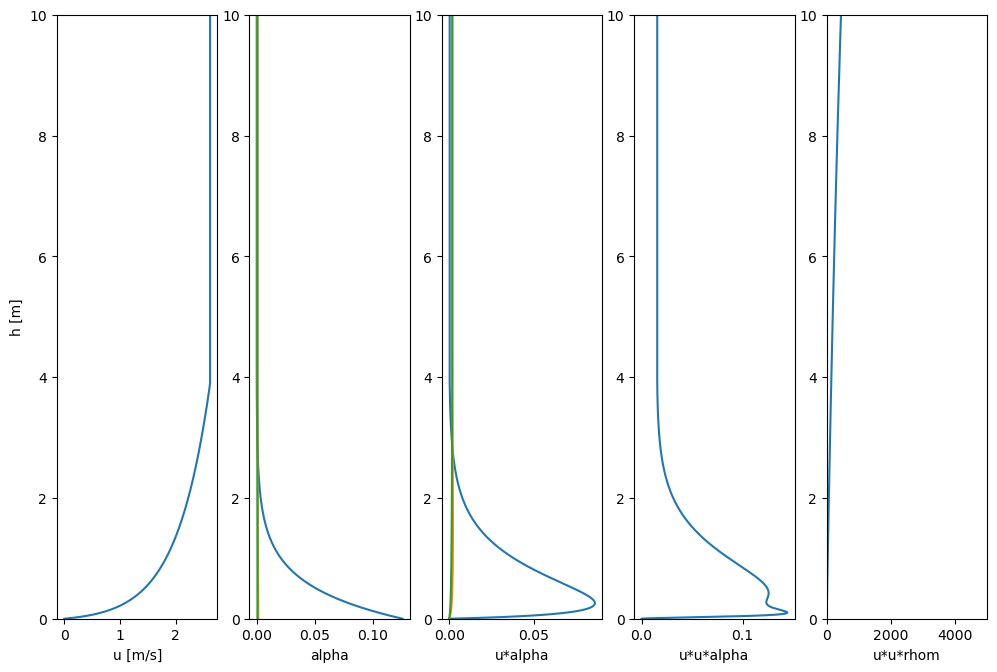

In [27]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)

nz = 100000
z = numpy.linspace(0,h,num=nz+1)
dz = h/nz


u_rel = u_coeff * sqrt(friction_coeff) / k * numpy.log( 30.0/k_s*numpy.minimum(h0,z) + 1.0 )

ax1.plot(u_avg*u_rel,z)

ax1.set(xlabel='u [m/s]', ylabel='h [m]')

ax1.set_ylim(0,h)

for i in range(np):

    a = -(0.6*Pn[i]*beta)/h

    int_ = ( ( numpy.exp(a*h0) -1.0 )/a + numpy.exp(a*h0)*(h-h0) )/h

    alpha_rel_max = 1.0/int_

    alpha_rel = alpha_rel_max * numpy.exp(a*(numpy.minimum(h0,z)))

    uualpha = uualpha + (u_avg*u_rel)*(u_avg*u_rel)*(alpha_avg[i]*alpha_rel)

    ax2.plot(alpha_avg[i]*alpha_rel,z)

    ax3.plot( (u_avg*u_rel) * (alpha_avg[i]*alpha_rel) ,z)
   
ax2.set(xlabel='alpha')
ax2.set_ylim(0,h)

ax3.set(xlabel='u*alpha')
ax3.set_ylim(0,h)

ax4.plot(uualpha,z)
ax4.set(xlabel='u*u*alpha')
ax4.set_ylim(0,h)

ax5.plot((u_avg*u_rel)*rhom_avg*U_int)
ax5.set(xlabel='u*u*rhom')
ax5.set_ylim(0,h)
ax5.set_xlim(0,5000)

print(u_avg*u_rel)